# An analysis of NBA players in the 2021/2022 season

We want to create a DataFrame containing information about all active players in the current NBA season, with the following structure:


| Personal Information |Player career statistics | Misc |
|   :---:    |   :---:   |   :---:   |
| player_id (int) (INDEX) | games played (int) | salary in US$(int) (this season only) |
| player_name (str) | minutes per game (float) | |
| team_name (str) | points per game (float) | |
| position (str) | rebounds per game (float) | |
| height (int) (in centimeters) | assists per game (float) | |
| weight (float) (in kilograms) |steals per game (float) | |
| country of origin (str) |blocks per game (float) | |
| date_of_birth (datetime) | | |
| age (str) (years and months) | | |
| years_of_experience (int) (years since entering the league) | | |
| Draft position (int) | | |


# Collecting information for building the dataset.

We use https://github.com/swar/nba_api to gather the data. 

This is a Python library that can be used to obtain data from stats.nba.com, it provides a set of methods that abstracts you from making the http calls, but directly makes calls to nba stats page and parses the results. [Here](https://github.com/swar/nba_api/blob/master/docs/examples/Basics.ipynb) are a couple of examples on how to use it. There is also a [tutorial](https://www.youtube.com/watch?v=a3u-3gEYvxM).    

## About the imports and the IDE

If we run the notebook in Colab, some modules have to be imported each time. Also we have to mount the notebook on the drive folder, so below we automate all of that.

We also get the appropriate path for whichever environment we are working on.

In [2]:
import os

if 'google.colab' in str(get_ipython()):
  # The -q key in pip is to not showcase all the importing module.
  # It is risky because you may not get error messages, but in this case it is to save time and space 
  # when running the notebook in Colaboratory.
  !pip install nba_api -q
  !pip install unidecode -q
  !pip install --upgrade geopandas -q
  !pip install descartes -q
  !pip install pycountry -q
  !pip install plotly_express -q
  print('nba_api, unidecode installed')
  from google.colab import drive
  drive.mount('/content/drive')
  #drive.flush_and_unmount()

  path = '/content/drive/My Drive/python_estudiando/' 
  import sys
  sys.path.insert(0,path)
else:
  print('Not running on CoLab')
  path = os.getcwd()+"/"

Not running on CoLab


In [3]:
import pandas as pd
import numpy as np
from time import sleep
from math import ceil

from dateutil import relativedelta
from datetime import datetime, date
from unidecode import unidecode

import seaborn as sns
import matplotlib.pyplot as plt

from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, commonallplayers, commonplayerinfo

import geopandas as gpd
from descartes import PolygonPatch

We create a function to find all ACTIVE players, meaning players listed with a team in the 2021/2022 season. 

The features player id, name, and team are enough. 
We drop: 
- All players with TEAM_ID == 0
- All players with GAMES_PLAYED_FLAG == N
- Players with id 1630597 & 1630492 (These guys are a problem ;))

In [ ]:
data= commonallplayers.CommonAllPlayers(season='2021-22')
df = data.get_data_frames()[0]
df = df.loc[df.GAMES_PLAYED_FLAG != "N"].loc[df.TEAM_ID != 0].loc[~df.PERSON_ID.isin([1630597, 1630492])]
df.to_csv(path+"nba_current_players_list.csv", index = False)


df_1 = pd.DataFrame()
for index, row in df.iterrows():
    data = playercareerstats.PlayerCareerStats(player_id = str(row.PERSON_ID))
    data = data.get_data_frames()[1]
    df_1 = pd.concat([df_1, data])
    sleep(0.5)
df_1.to_csv(path+"nba_players_career_stats.csv", index=False)


# Find the personal information of all players listed in the dataframe created in the previous step. 
df_1 = pd.DataFrame()
for index, row in df.iterrows():
    data= commonplayerinfo.CommonPlayerInfo(player_id = str(row.PERSON_ID))
    data = data.get_data_frames()[0]
    df_1 = pd.concat([df_1, data])
    sleep(0.5)
df_1.to_csv(path+"nba_players_personal_info.csv", index=False)

del df
del df_1
del data

## Function to find players salary

We get the list of players and salaries from [contracts.csv]

Some work on the format of the names is needed.

There are players whose name has a suffix, such as 'David Duke Jr.', 'Kevin Knox II', 'Marcus Morris Sr.', 'Robert Williams III', etc..

This may present an issue merging the 2 databases; some may appear with the suffix in one table but not on the other(or viceversa).

For each table, let´s get the set of players with suffixes.

In [ ]:
def string_cleaner(s):
  """
  This functions tries to unify the format of the names of nba players
  """
  return unidecode(s.rstrip().lstrip().lower())

contratos = pd.read_csv(path + "contracts.csv")
contratos.columns = contratos.iloc[0]
contratos = contratos.iloc[1: , :]
contratos = contratos[["Player", "Tm", "2021-22", "Signed Using", "Guaranteed"]]

# Fix player names
contratos[['Player', 'bkref_code']] = contratos['Player'].str.split('\\', expand=True)
contratos.Player = contratos.Player.apply(string_cleaner)

# Drop duplicates
contratos = contratos.drop_duplicates(subset=["Player", "2021-22"], keep='first')

# Fix salaries column, convert to numeric
contratos["2021-22"] = contratos["2021-22"].apply(lambda s: float(str(s).replace("$","")))   

# We read the nba_players_list  
current_players_list = pd.read_csv(path+"nba_current_players_list.csv")

# Fix player names
current_players_list['PLAYER_NAME'] = current_players_list.DISPLAY_FIRST_LAST.apply(string_cleaner)

#----------------------------------------------------------------------------------------------
long_names_nba_api = [x for x in current_players_list.PLAYER_NAME if len(x.split()) > 2]
sufixes_nba_api = set([" ".join(x.split()[2:]) for x in long_names_nba_api])
print(" On nba_current_players_list there are names with sufixes such as : \n\n", sufixes_nba_api, "\n")

long_names_contracts = [x for x in contratos.Player if len(x.split()) > 2]
sufixes_contracts = set([" ".join(x.split()[2:]) for x in long_names_contracts])
print(" On contracts.csv there are names with sufixes such as : \n\n", sufixes_contracts, "\n")

 On nba_current_players_list there are names with sufixes such as : 

 {'ii', 'iii', 'iv', 'sr.', 'jr.'} 

 On contracts.csv there are names with sufixes such as : 

 {'ii', 'iii', 'sr.', 'iv', 'jr.'} 



Let´s verify whether we can work with sets instead of lists:

In [ ]:
len(long_names_contracts) == len(set(long_names_contracts)), len(long_names_nba_api) == len(set(long_names_nba_api))

(True, True)

In [ ]:
long_names_contracts = set(long_names_contracts)
long_names_nba_api = set(long_names_nba_api)

#nbaapi_to_contracts_dictionary = {x:x for x in long_names_contracts.intersection(long_names_nba_api)}
nbaapi_to_contracts_dictionary = {}
nbaapi_to_contracts_dictionary.update({" ".join(x.split()[:2]): x for x in long_names_contracts.difference(long_names_nba_api)})
nbaapi_to_contracts_dictionary.update({x:" ".join(x.split()[:2]) for x in long_names_nba_api.difference(long_names_contracts)})

nbaapi_to_contracts_dictionary

{'brandon boston': 'brandon boston jr.',
 'dennis smith': 'dennis smith jr.',
 'robert williams iii': 'robert williams',
 'duane washington jr.': 'duane washington',
 'kevin knox ii': 'kevin knox',
 'chaundee brown jr.': 'chaundee brown',
 'david duke jr.': 'david duke',
 'marcus morris sr.': 'marcus morris',
 'mckinley wright iv': 'mckinley wright',
 'melvin frazier jr.': 'melvin frazier',
 'rj nembhard jr.': 'rj nembhard',
 'lindy waters iii': 'lindy waters'}

In [ ]:
df = pd.read_csv(path + "contracts.csv")
df.head()

Unnamed: 0                   Unnamed: 1 Unnamed: 2     Salary   Salary.1  \
0         Rk                       Player         Tm    2021-22    2022-23   
1          1      Stephen Curry\curryst01        GSW  $45780966  $48070014   
2          2           John Wall\walljo01        HOU  $44310840  $47366760   
3          3  Russell Westbrook\westbru01        LAL  $44211146  $47063478   
4          4       James Harden\hardeja01        PHI  $43848000  $46872000   

    Salary.2   Salary.3   Salary.4 Salary.5    Unnamed: 9 Unnamed: 10  
0    2023-24    2024-25    2025-26  2026-27  Signed Using  Guaranteed  
1  $51915615  $55761216  $59606817      NaN   Bird Rights  $261134628  
2        NaN        NaN        NaN      NaN   Bird Rights   $44310840  
3        NaN        NaN        NaN      NaN   Bird Rights   $44211146  
4        NaN        NaN        NaN      NaN   Bird Rights   $43848000

In [ ]:
# Una solución más linda en código.

def get_nba_players_salaries(csv_file_path):
  salary_df = pd.read_csv(csv_file_path, header=1, names=['PLAYER_NAME', 'SALARY'], usecols=[1,3]) 
  return (salary_df
          .assign(PLAYER_NAME = lambda salary_df: salary_df.PLAYER_NAME
                  .str.split('il', 1).str[0]
                  .apply(unidecode)
                  )
          .assign (SALARY = lambda salary_df: salary_df.SALARY.str.split('$', 1).str[1])
          .drop_duplicates(subset='PLAYER_NAME', keep='first')
          .replace({ 'PLAYER_NAME': nbaapi_to_contracts_dictionary })
          )

In [ ]:
def get_nba_players_salaries(csv_file_path):
  """
  Return a dataframe with the players salary

  Parameters
  ----------
  'csv_file_path: CSV File
    csv_with salary information

  Returns
  -------
  Pandas Dataframe
    Dataframe with salary information of active players in the 2021/2022 season
  """
  
  df = pd.DataFrame()
  df["PERSON_ID"] = current_players_list.PERSON_ID
  df["PLAYER_NAME"] = current_players_list.DISPLAY_FIRST_LAST
  df["SALARY"] = np.nan
  
  for index, row in current_players_list.iterrows():
    # Here we get the salaries of players that present no issues so far  
    try:
      df.at[index, "SALARY"] = contratos.loc[contratos.Player == row.PLAYER_NAME]["2021-22"].values[0]
    except IndexError:
      pass

    # Now for players with diferences in their suffixes
    if row.PLAYER_NAME in nbaapi_to_contracts_dictionary:
      try:
        df.at[index, "SALARY"] = contratos.loc[contratos.Player == nbaapi_to_contracts_dictionary[row.PLAYER_NAME]]["2021-22"].values[0]
      except IndexError:
        pass
  #df.to_csv(path+"nba_players_salary.csv", index=False)
  df.SALARY = df.SALARY.astype('Int64').astype(str)
  return df

players_salaries = get_nba_players_salaries(path + "contracts.csv")
# players_salaries[players_salaries.isna().any(axis=1)]  # show any row with NaNs.

In [ ]:
index_salary_1 = players_salaries[players_salaries['PLAYER_NAME']=='Kyrie Irving'].index.values[0]
index_salary_2 = players_salaries[players_salaries['PLAYER_NAME']=='Luke Kennard'].index.values[0]

if players_salaries.SALARY.loc[index_salary_1] == '34916200' and players_salaries.SALARY.loc[index_salary_2] == '12727273':
    print('Success!')
else:
    raise ValueError('The salaries are incorrect, please review your function')

Success!


### Merging DataFrames 

Before merging, make sure all dataframes have the same length, are indexed by PERSON_ID and have the same keys. 

In [ ]:
nba_players_list = pd.read_csv(path+"nba_current_players_list.csv")
players_career_stats = pd.read_csv(path+"nba_players_career_stats.csv")[["PLAYER_ID", "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK"]].rename(columns={"PLAYER_ID":"PERSON_ID"})
players_personal_info = pd.read_csv(path+"nba_players_personal_info.csv")
players_personal_info = players_personal_info[["PERSON_ID", 'DISPLAY_FIRST_LAST', "TEAM_NAME", "POSITION", "HEIGHT", "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER"]] \
                             .rename(columns={'DISPLAY_FIRST_LAST':"PLAYER_NAME"})
 
# 1.4
players_salaries = pd.read_csv(path+"nba_players_salary.csv")[["PERSON_ID", "SALARY"]]

def merge_dataframes(players_personal_info, players_career_stats, players_salaries):
    df = pd.merge(players_personal_info, players_career_stats, on="PERSON_ID")
    df = pd.merge(df, players_salaries, on="PERSON_ID")
    df.index = df.PERSON_ID.values
    df = df.iloc[:,1:]
    return df 

raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, players_salaries)
raw_players_dataset.to_csv(path+"raw_nba_players_dataset.csv", index=False)

raw_players_dataset.head()

PLAYER_NAME  TEAM_NAME        POSITION HEIGHT  WEIGHT  \
1630173   Precious Achiuwa    Raptors         Forward    6-8     225   
203500        Steven Adams  Grizzlies          Center   6-11     265   
1628389        Bam Adebayo       Heat  Center-Forward    6-9     255   
1630583       Santi Aldama  Grizzlies  Forward-Center   6-11     215   
200746   LaMarcus Aldridge       Nets  Center-Forward   6-11     250   

             COUNTRY            BIRTHDATE  SEASON_EXP DRAFT_NUMBER    GP  \
1630173      Nigeria  1999-09-19T00:00:00           2           20   134   
203500   New Zealand  1993-07-20T00:00:00           9           12   664   
1628389          USA  1997-07-18T00:00:00           5           14   343   
1630583        Spain  2001-01-10T00:00:00           1           30    32   
200746           USA  1985-07-19T00:00:00          16            2  1076   

             MIN    PTS   REB   AST  STL   BLK      SALARY  
1630173   2462.0    968   681   111   57    69   2711280.0  
203500   17811.0   6157  5303   982  588   629  17073171.0  
1628389   9666.0   4617  2850  1189  340   309  28103550.0  
1630583    360.0    132    87    21    6    10   1994520.0  
200746   36242.0  20558  8736  2076  758  1187   2641691.0

##2. Data Cleaning and Preprocessing

In [ ]:
raw_players_dataset = pd.read_csv(path+"raw_nba_players_dataset.csv")

working_df = raw_players_dataset.copy()                                         # Create a copy of your dataset named "working_df"
working_df.dropna(subset=["TEAM_NAME", "SALARY"], inplace=True)                 # remove all players with no teams or salary
# df[df.SALARY.notna() & df.TEAM_NAME.notna()]                                  # other way of copying and deleting NaNs:
working_df.SALARY = working_df.SALARY.astype(int)                               # Cast Salary and Birthday columns to its corresponding type (int, datetime)
working_df.BIRTHDATE = pd.to_datetime(working_df.BIRTHDATE, format="%Y-%m-%d")
working_df.POSITION=working_df.POSITION.str.split("-",n=2,expand=True).iloc[:,0] # Replace all mixed positions with the first one listed.
working_df.WEIGHT = ((working_df.WEIGHT)*0.453592).apply(round)                 # convert the weight column from pounds to kilograms

def pulgadas_a_centimetros(s):                                                  # convert the height column from height in feet and inches to centimeters
  [a,b] = s.split("-")
  return round(2.54*(12*int(a)+int(b)))
working_df["HEIGHT"] = working_df.HEIGHT.apply(lambda s: pulgadas_a_centimetros(str(s)))

In [ ]:
index_df_1 = working_df[working_df['PLAYER_NAME']=='Kyrie Irving'].index.values[0]
index_df_2 = working_df[working_df['PLAYER_NAME']=='Luke Kennard'].index.values[0]

if working_df.SALARY.dtype == 'int64' and working_df.BIRTHDATE.dtype == '<M8[ns]':
    print('Success!')
else:
    raise ValueError('The data types of SALARY, BIRTHDATE are incorrect, please review your function')

Success!
Success!
Success!
Success!


### If a player does not have height or weight data, use the average for its position as its value

HEIGHT, WEIGHT have no nulls, but anyway:


In [ ]:
dicci_positions = {position:{colu: working_df.loc[working_df.POSITION == position][colu].mean() for colu in ["WEIGHT", "HEIGHT"]} for position in working_df.POSITION.unique()}
dicci_positions

{'Forward': {'WEIGHT': 102.43529411764706, 'HEIGHT': 203.00588235294117},
 'Center': {'WEIGHT': 113.87096774193549, 'HEIGHT': 210.66129032258064},
 'Guard': {'WEIGHT': 90.24378109452736, 'HEIGHT': 192.60199004975124}}

In [ ]:
for index, row in working_df.iterrows():
  for colu in ["WEIGHT", "HEIGHT"]:
    if row.isna()[colu]:
      row[colu] = dicci_positions[row.POSITION][colu] 

In [ ]:
today = pd.Timestamp(pd.Timestamp.now().date())
today

Timestamp('2022-10-07 00:00:00')

In [ ]:
def calcular_edad(fecha, hoy):
  diff = relativedelta.relativedelta(hoy, fecha)
  return '{} years, {} months, {} days'.format(diff.years, diff.months, diff.days)
  
hoy = date.today()
working_df["AGE"] = working_df.BIRTHDATE.apply(lambda s: calcular_edad(s, hoy))

#working_df.loc[(working_df.BIRTHDATE.dt.month==9) & (working_df.BIRTHDATE.dt.day==15)]

In [ ]:
# Carlos Concha calculó la edad de días de un jugador así, pero por supuesto falta contar los años bisiestos.
working_df.assign(Edad = lambda x: working_df.BIRTHDATE.rsub(pd.Timestamp("now")), inplace=True)

PLAYER_NAME  TEAM_NAME POSITION  HEIGHT  WEIGHT      COUNTRY  \
0     Precious Achiuwa    Raptors  Forward     203     102      Nigeria   
1         Steven Adams  Grizzlies   Center     211     120  New Zealand   
2          Bam Adebayo       Heat   Center     206     116          USA   
3         Santi Aldama  Grizzlies  Forward     211      98        Spain   
4    LaMarcus Aldridge       Nets   Center     211     113          USA   
..                 ...        ...      ...     ...     ...          ...   
495       Delon Wright    Wizards    Guard     196      84          USA   
499     Thaddeus Young    Raptors  Forward     203     107          USA   
500         Trae Young      Hawks    Guard     185      74          USA   
501     Omer Yurtseven       Heat   Center     211     125       Turkey   
502        Ivica Zubac   Clippers   Center     213     109      Croatia   

     BIRTHDATE  SEASON_EXP DRAFT_NUMBER    GP  ...    PTS   REB   AST   STL  \
0   1999-09-19           2           20   134  ...    968   681   111    57   
1   1993-07-20           9           12   664  ...   6157  5303   982   588   
2   1997-07-18           5           14   343  ...   4617  2850  1189   340   
3   2001-01-10           1           30    32  ...    132    87    21     6   
4   1985-07-19          16            2  1076  ...  20558  8736  2076   758   
..         ...         ...          ...   ...  ...    ...   ...   ...   ...   
495 1992-04-26           7           20   411  ...   2952  1318  1246   474   
499 1988-06-21          15           12  1085  ...  13848  6345  2003  1535   
500 1998-09-19           4            5   280  ...   7076  1085  2544   262   
501 1998-06-19           1    Undrafted    56  ...    299   294    49    17   
502 1997-03-18           6           32   360  ...   3001  2350   410   112   

      BLK    SALARY                          AGE                     Edad_2  \
0      69   2711280   23 years, 0 months, 9 days  8410 days 19:09:55.947827   
1     629  17073171   29 years, 2 months, 8 days 10662 days 19:09:55.947827   
2     309  28103550  25 years, 2 months, 10 days  9203 days 19:09:55.947827   
3      10   1994520  21 years, 8 months, 18 days  7931 days 19:09:55.947827   
4    1187   2641691   37 years, 2 months, 9 days 13585 days 19:09:55.947827   
..    ...       ...                          ...                        ...   
495   148   8526316   30 years, 5 months, 2 days 11112 days 19:09:55.947827   
499   448  14190000   34 years, 3 months, 7 days 12517 days 19:09:55.947827   
500    42   8326471   24 years, 0 months, 9 days  8775 days 19:09:55.947827   
501    20   1489065   24 years, 3 months, 9 days  8867 days 19:09:55.947827   
502   304   7518518  25 years, 6 months, 10 days  9325 days 19:09:55.947827   

                          Edad inplace  
0    8410 days 19:10:22.555838    True  
1   10662 days 19:10:22.555838    True  
2    9203 days 19:10:22.555838    True  
3    7931 days 19:10:22.555838    True  
4   13585 days 19:10:22.555838    True  
..                         ...     ...  
495 11112 days 19:10:22.555838    True  
499 12517 days 19:10:22.555838    True  
500  8775 days 19:10:22.555838    True  
501  8867 days 19:10:22.555838    True  
502  9325 days 19:10:22.555838    True  

[433 rows x 21 columns]

In [ ]:
# una manera bruta de obtener la eda
today = datetime.now()
working_df["Edad_2"] = today-working_df.BIRTHDATE

In [ ]:
datetime.now()

datetime.datetime(2022, 9, 28, 18, 46, 37, 812825)

In [ ]:
date.today()

datetime.date(2022, 9, 28)

* Review that the dataset has all requested columns with its corresponding datatypes and save it as "nba_players_processed_dataset.csv"

In [ ]:
# transform basic game stats to averages per game instead of season totals
working_df[["MIN", "PTS", "REB", "AST", "STL", "BLK"]] = (working_df[["MIN", "PTS", "REB", "AST", "STL", "BLK"]]).div(working_df.GP, axis=0).round(decimals=1)

working_df.DRAFT_NUMBER.replace('Undrafted',"", inplace=True)
working_df.DRAFT_NUMBER.replace(np.nan,"", inplace=True)
working_df.DRAFT_NUMBER = pd.to_numeric(working_df.DRAFT_NUMBER, errors='coerce')
working_df.DRAFT_NUMBER = working_df.DRAFT_NUMBER.astype('Int64')

working_df.to_csv(path+"nba_players_processed_dataset.csv")

## 3. Analyzing and Visualizing data

In [4]:
working_df = pd.read_csv(path+"nba_players_processed_dataset.csv", index_col="Unnamed: 0")
working_df.loc[working_df.index.isin([200765, 203107, 204060])]

PLAYER_NAME  TEAM_NAME POSITION  HEIGHT  WEIGHT         COUNTRY  \
204060        Joe Ingles      Bucks  Forward     203     100       Australia   
200765       Rajon Rondo  Cavaliers    Guard     185      82             USA   
203107  Tomas Satoransky    Wizards    Guard     201      95  Czech Republic   

         BIRTHDATE  SEASON_EXP  DRAFT_NUMBER   GP   MIN  PTS  REB  AST  STL  \
204060  1987-10-02           8           NaN  590  25.7  8.6  3.2  3.8  0.9   
200765  1986-02-22          17          21.0  957  29.9  9.8  4.5  7.9  1.6   
203107  1991-10-30           7          32.0  388  22.2  6.9  2.9  4.1  0.8   

        BLK    SALARY                           AGE  
204060  0.2  14000000  34 years, 11 months, 15 days  
200765  0.1   2641691   36 years, 6 months, 26 days  
203107  0.2  10468119  30 years, 10 months, 18 days

In [ ]:
a=len(working_df)
b=working_df.loc[working_df.COUNTRY == "USA"].shape[0]
c=working_df.loc[working_df.SEASON_EXP == 1].shape[0]

print(f"Total number of players:     {a} \nNumber of USA born players:  {b} \nNumber of foreign players:   {a-b}  ")
print("\nNumber of players per position: \n")
print(f"\nNumber of rookies: {c}")

for idx,name in enumerate(working_df.POSITION.value_counts().index.tolist()):
    print('\t', name,"   \t", working_df.POSITION.value_counts()[idx])

 - General metrics: 

Total number of players:     433 
Number of USA born players:  327 
Number of foreign players:   106  

Number of players per position: 

	 Guard    	 201
	 Forward    	 170
	 Center    	 62

Number of rookies: 55


Letś have fun with the number of players per team. To showcase it, we will have the number of desired columns as a parameter.

In [ ]:
def showcase_team_players():  
  nof_cols= None
  while nof_cols not in range(1,7):
    try:
      nof_cols = eval(input("Please insert number of columns, from 1 to 6.\nWe are limited by the width of the cell output.\n"))
    except NameError:
      print("The input has to be an INTEGER, from 1 to 6.")

  print("\nNumber of players per team: \n")
  columna = working_df.TEAM_NAME

  nof_rows = ceil(working_df.TEAM_NAME.nunique()/nof_cols)
  lines = ["" for i in range(nof_rows)]
  longitud_util = 1 + max([len(i) for i in columna.unique()])
  spaces_to_number = 1+len(str(columna.value_counts().max()))

  bloque = "Team".ljust(longitud_util," ")+"#"+" "*spaces_to_number+"\t"
  print(bloque*nof_cols , "\n"+"-"*len(bloque)*(1+nof_cols))
  for idx,name in enumerate(columna.value_counts().index.tolist()):
    lines[idx % nof_rows] += name.ljust(longitud_util," ")+str(columna.value_counts()[idx]).ljust(spaces_to_number)+"\t"
  for i in lines:
    print(i)

showcase_team_players()

Please insert number of columns, from 1 to 6.
We are limited by the width of the cell output.
6

Number of players per team: 

Team          #   	Team          #   	Team          #   	Team          #   	Team          #   	Team          #   	 
-------------------------------------------------------------------------------------------------------------------------------------
Raptors       17 	76ers         16 	Grizzlies     15 	Hornets       14 	Celtics       13 	Hawks         13 	
Rockets       17 	Cavaliers     16 	Pelicans      15 	Bucks         14 	Heat          13 	Mavericks     12 	
Lakers        17 	Pistons       16 	Wizards       15 	Clippers      14 	Spurs         13 	Pacers        12 	
Bulls         17 	Suns          15 	Timberwolves  15 	Thunder       14 	Magic         13 	Knicks        12 	
Jazz          16 	Trail Blazers 15 	Nets          15 	Nuggets       14 	Warriors      13 	Kings         12 	


In [5]:
df=pd.DataFrame()
df[["years_", "1", "months_", "2", "days_", "3"]] = working_df.AGE.str.split(expand=True)
df = df[["years_","months_","days_"]].astype(int)
x=(df.sum()/len(df)).values
print(" Average player age (in years): ", int(x[0]+x[1]/12+x[2]/365))
del df

print(" Youngest player age: \t", working_df.loc[working_df.BIRTHDATE==working_df.BIRTHDATE.max()].AGE.values[0])
print(" Oldest player age: \t", working_df.loc[working_df.BIRTHDATE==working_df.BIRTHDATE.min()].AGE.values[0], "\n")
print(" Min players height: \t",working_df.HEIGHT.min(),"cm")
print(" Max players height: \t",working_df.HEIGHT.max(),"cm")
print("\n Average height of players per position: \n")
for idx,name in enumerate(working_df.POSITION.value_counts().index.tolist()):
    print('\t', name," "*(13-len(name))+"\t", working_df.loc[working_df.POSITION == name].HEIGHT.mean().round(1), "cm")

print("\nCONTRACTS\n")
print(" Min players salary: \t\t US$",working_df.SALARY.min())
print(" Max players salary: \t\t US$",working_df.SALARY.max())
print(" Mean salary of all players: \t US$",working_df.SALARY.mean().round())
print(" Median salary of all players: \t US$",working_df.SALARY.median().round())

 Average player age (in years):  27
 Youngest player age: 	 19 years, 8 months, 24 days
 Oldest player age: 	 42 years, 3 months, 8 days 

 Min players height: 	 178 cm
 Max players height: 	 221 cm

 Average height of players per position: 

	 Guard         	 192.6 cm
	 Forward       	 203.0 cm
	 Center        	 210.7 cm

CONTRACTS

 Min players salary: 		 US$ 85578
 Max players salary: 		 US$ 45780966
 Mean salary of all players: 	 US$ 8983220.0


AttributeError: 'float' object has no attribute 'round'

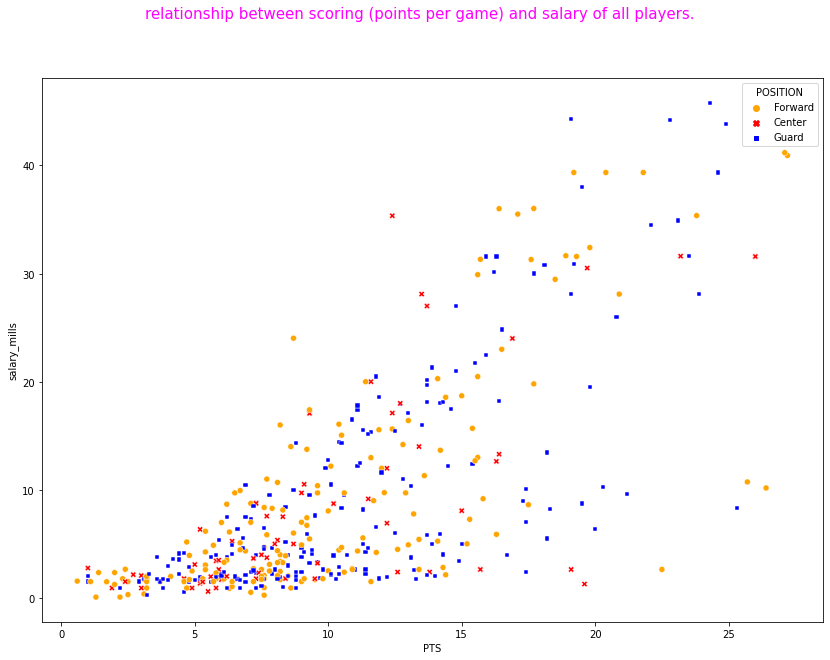

In [ ]:
working_df["salary_mills"] = working_df["SALARY"]/10**6

fig = plt.gcf()
fig.set_size_inches(14, 10)
fig.suptitle("relationship between scoring (points per game) and salary of all players.", fontsize=15, c="magenta")
sns.scatterplot(data=working_df, y="salary_mills", x="PTS", hue="POSITION", style="POSITION", palette = {"Forward": "orange", "Guard":"blue", "Center": "red"})
plt.ticklabel_format(style='plain', axis='x')

## 3.3- Plot assists-vs-salary and rebounding-vs-salary

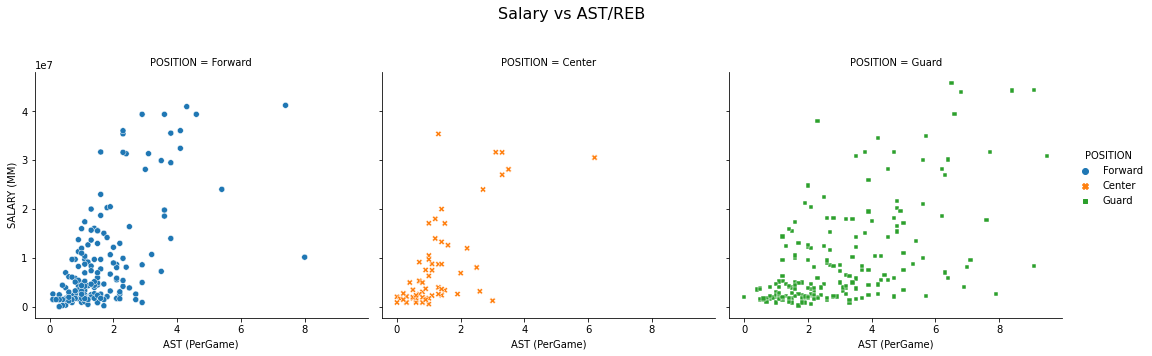

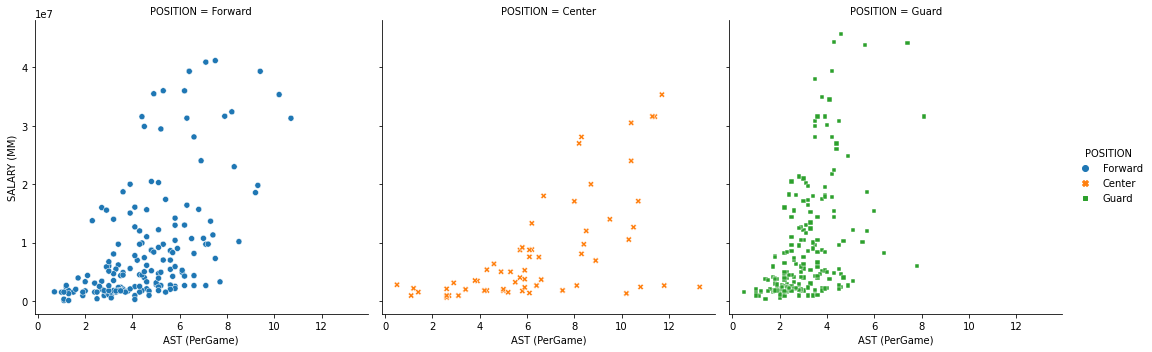

In [ ]:
a= sns.relplot(data=working_df, x='AST', y='SALARY', col="POSITION", hue="POSITION", style="POSITION")
a.figure.subplots_adjust(top=.8)
a.figure.suptitle('Salary vs AST/REB', size= 16)
a.set(ylabel='SALARY (MM)') 
a.set(xlabel="AST (PerGame)")
b = sns.relplot(data=working_df, x='REB', y='SALARY', col='POSITION', hue="POSITION", style="POSITION").set(ylabel='SALARY (MM)')
b.set(xlabel='AST (PerGame)')

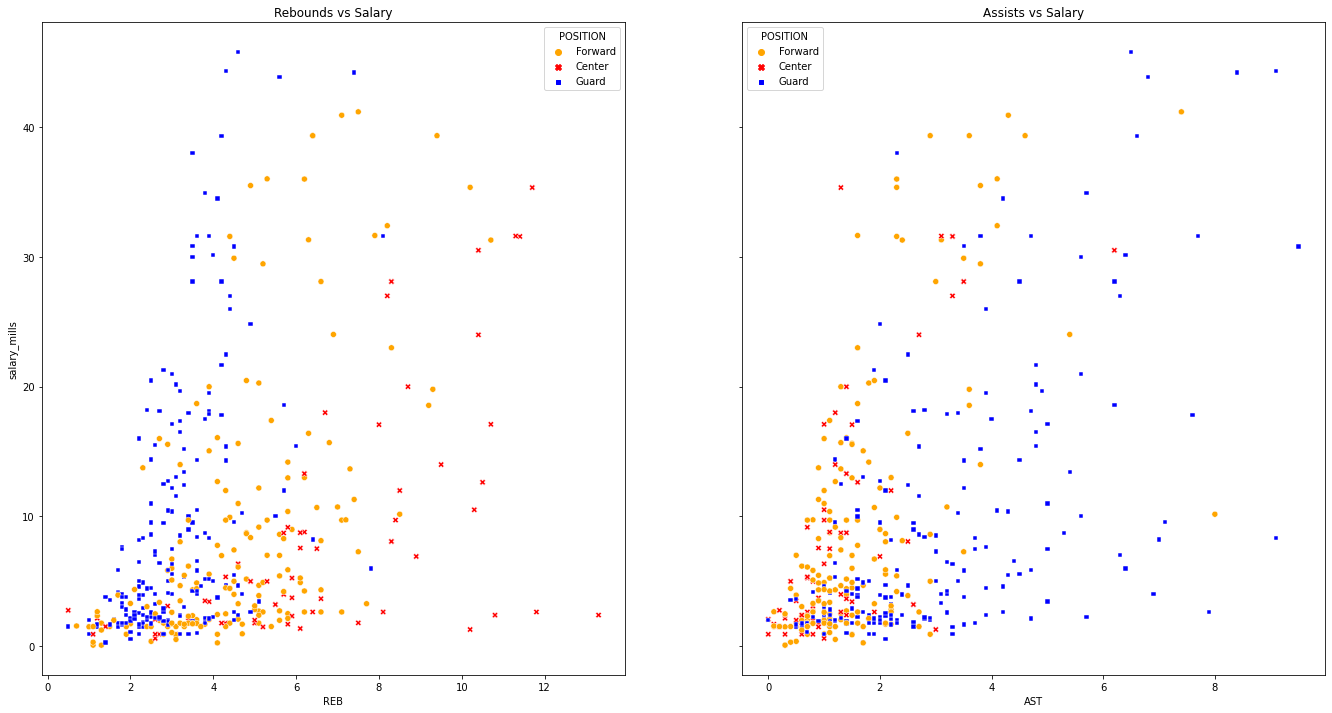

In [ ]:
dicci = {"REB":"Rebounds", "AST":"Assists"}
fig, ax = plt.subplots(1, len(dicci), figsize=(23, 12), sharey=True)
for i,col in enumerate(dicci):
  sns.scatterplot(data=working_df, y="salary_mills", x=col, hue="POSITION", style="POSITION", palette = {"Forward": "orange", "Guard":"blue", "Center": "red"}, \
                  ax=ax[i]).set_title(f"{dicci[col]} vs Salary")

3.4- When NBA players enter the league they have low value salaries during their rookie contract, regardless of how they perform. Lets plot points, assists and rebounding vs salary, but only for players that have more than 4 years of experience (the typical length of a rookie contract).

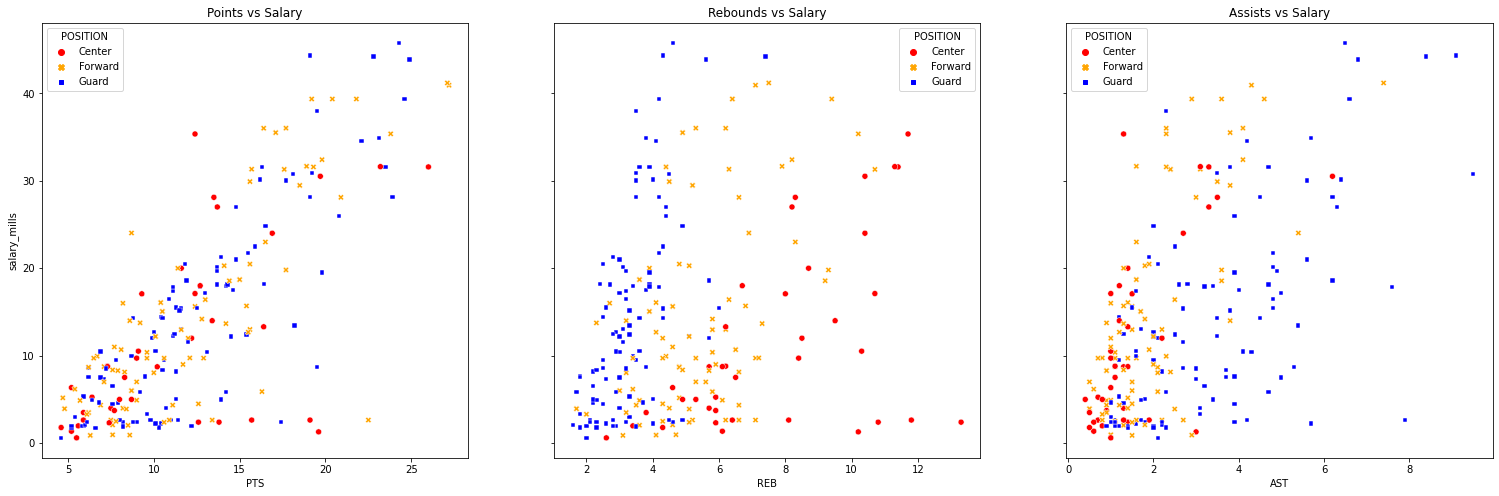

In [ ]:
df=working_df.loc[working_df.SEASON_EXP>4]
dicci = {"PTS":"Points", "REB":"Rebounds", "AST":"Assists"}

fig, ax = plt.subplots(1, len(dicci), figsize=(26, 8), sharey=True)
for i,col in enumerate(dicci):
  sns.scatterplot(data=df, y="salary_mills", x=col, hue="POSITION", style="POSITION", palette = {"Forward": "orange", "Guard":"blue", "Center": "red"}, \
                  ax=ax[i]).set_title(f"{dicci[col]} vs Salary")

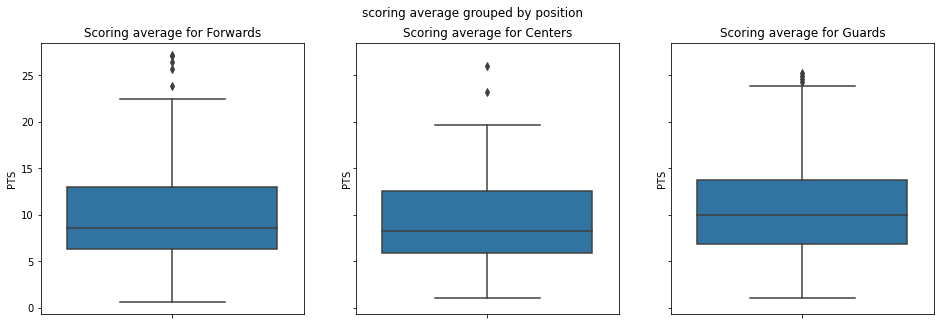

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
plt.suptitle("scoring average grouped by position")
for i,col in enumerate(working_df.POSITION.unique()):
  sns.boxplot(data=working_df.loc[working_df.POSITION==col], y="PTS", ax=ax[i]).set_title(f"Scoring average for {col}s")

[Text(0.5, 1.0, 'Height distribution of all players')]

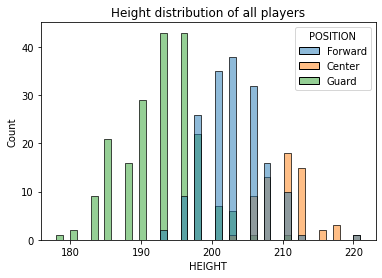

In [ ]:
sns.histplot(data=working_df, x="HEIGHT",  hue = "POSITION", bins=1+working_df.HEIGHT.max() - working_df.HEIGHT.min()).set(title='Height distribution of all players')

## Let's draw a world map and show how many active players per country the NBA has

Just for fun

[Example](https://i.redd.it/8qymui9fnin71.jpg)

In [9]:
import pycountry
import plotly.express as px
import geopandas as gpd

In [13]:
countries = pd.DataFrame(working_df.COUNTRY.value_counts()).reset_index()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries.replace({'USA': 'United States of America', 
                   'Czech Republic':'Czechia', 
                   'Dominican Republic':'Dominican Rep.',
                   'DRC':'Dem. Rep. Congo',
                   'Republic of the Congo':'Congo',
                   'Bosnia and Herzegovina':
                   'Bosnia and Herz.'}, inplace=True)
merged = world.merge(countries, how="left", left_on=['name'], right_on=["index"])
cleaned = merged.dropna(subset=["index"])[['name', "geometry", "COUNTRY"]]
cleaned.columns = ['COUNTRY', 'geometry', 'PLAYERS']

In [14]:
cleaned.head()

COUNTRY  \
3                     Canada   
4   United States of America   
9                  Argentina   
11           Dem. Rep. Congo   
14                     Sudan   

                                             geometry  PLAYERS  
3   MULTIPOLYGON (((-122.84000 49.00000, -122.9742...     17.0  
4   MULTIPOLYGON (((-122.84000 49.00000, -120.0000...    327.0  
9   MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...      2.0  
11  POLYGON ((29.34000 -4.49998, 29.51999 -5.41998...      2.0  
14  POLYGON ((24.56737 8.22919, 23.80581 8.66632, ...      1.0

In [15]:
fig = px.choropleth(cleaned, 
                    geojson=cleaned.geometry,
                    locations=cleaned.index,
                    color="PLAYERS", 
                    height=600,
                    range_color=(1,30),
                    hover_name='COUNTRY',
                    hover_data=['PLAYERS'],
                    color_continuous_scale = "Bluered"
                    )

fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout( title_text="NBA Active Players Around the World")

fig.update(layout = dict(title=dict(x=0.5)))

fig.update_layout(margin = { "r":0,"t":30,"l":10,"b":10}, 
                  coloraxis_colorbar = {'title': 'Sum'}
                  )
fig.update(layout_coloraxis_showscale=False)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [16]:
bonus_2 = working_df[['COUNTRY', 'SALARY']].groupby('COUNTRY').agg(['count', 'mean','sum'])['SALARY'].reset_index().rename(columns={ 'COUNTRY':"country"})
 
def country_convert(x):
  try:
    y = pycountry.countries.get(name=x).alpha_3
  except:
    y= np.nan
  return y
  
bonus_2. replace(to_replace=['USA', 'DRC', 'Republic of the Congo', 'Czech Republic'],
                      value=[ 'United States', 'Congo, The Democratic Republic of the','Congo', 'Czechia'],
                   inplace = True
                 )
bonus_2['country_iso'] = bonus_2['country'].apply(lambda x: country_convert(x))
fig = px.choropleth(bonus_2, locations="country_iso", color="count", hover_name="country") #, animation_frame='sum'
fig.update_layout(title_text='Active players per country')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [17]:
# We create this geodataframe
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

print("The following countries appear differently named on each dataset.")
for coco in working_df.COUNTRY.unique() :
  if coco not in df_world.name.unique():
    print(coco)

# we create an auxiliary column to fix that.
def translator(x):
  dicci = {"USA": 'United States of America',
           "DRC": 'Dem. Rep. Congo',
           "Dominican Republic": 'Dominican Rep.',
           "Republic of the Congo" : 'Congo',
           "Czech Republic": 'Czechia',
           "Bosnia and Herzegovina": 'Bosnia and Herz.'
           }
  if x in dicci:
    return dicci[x]
  else:
    return x

working_df["paises"] = working_df.COUNTRY.apply(translator)

countries_dict = working_df.paises.value_counts().to_dict()
df_world["players"] = df_world.name.map(countries_dict) 

nba_world = df_world.loc[df_world.name.isin(countries_dict)]
nba_world["centroid"] = nba_world.centroid

# I did not find Saint Lucia in the df_world countries list.
working_df.loc[working_df.COUNTRY=="Saint Lucia"]

The following countries appear differently named on each dataset.
USA
DRC
Saint Lucia
Dominican Republic
Republic of the Congo
Czech Republic
Bosnia and Herzegovina


/tmp/ipykernel_573803/542505492.py:29: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/home/eduardo/miniconda3/envs/anyone_1_2_3/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PLAYER_NAME TEAM_NAME POSITION  HEIGHT  WEIGHT      COUNTRY  \
1628449  Chris Boucher   Raptors  Forward     206      91  Saint Lucia   

          BIRTHDATE  SEASON_EXP  DRAFT_NUMBER   GP   MIN  PTS  REB  AST  STL  \
1628449  1993-01-11           5           NaN  231  17.9  9.0  5.3  0.5  0.5   

         BLK   SALARY                         AGE       paises  
1628449  1.2  7009615  29 years, 8 months, 6 days  Saint Lucia

NameError: name 'Line2D' is not defined

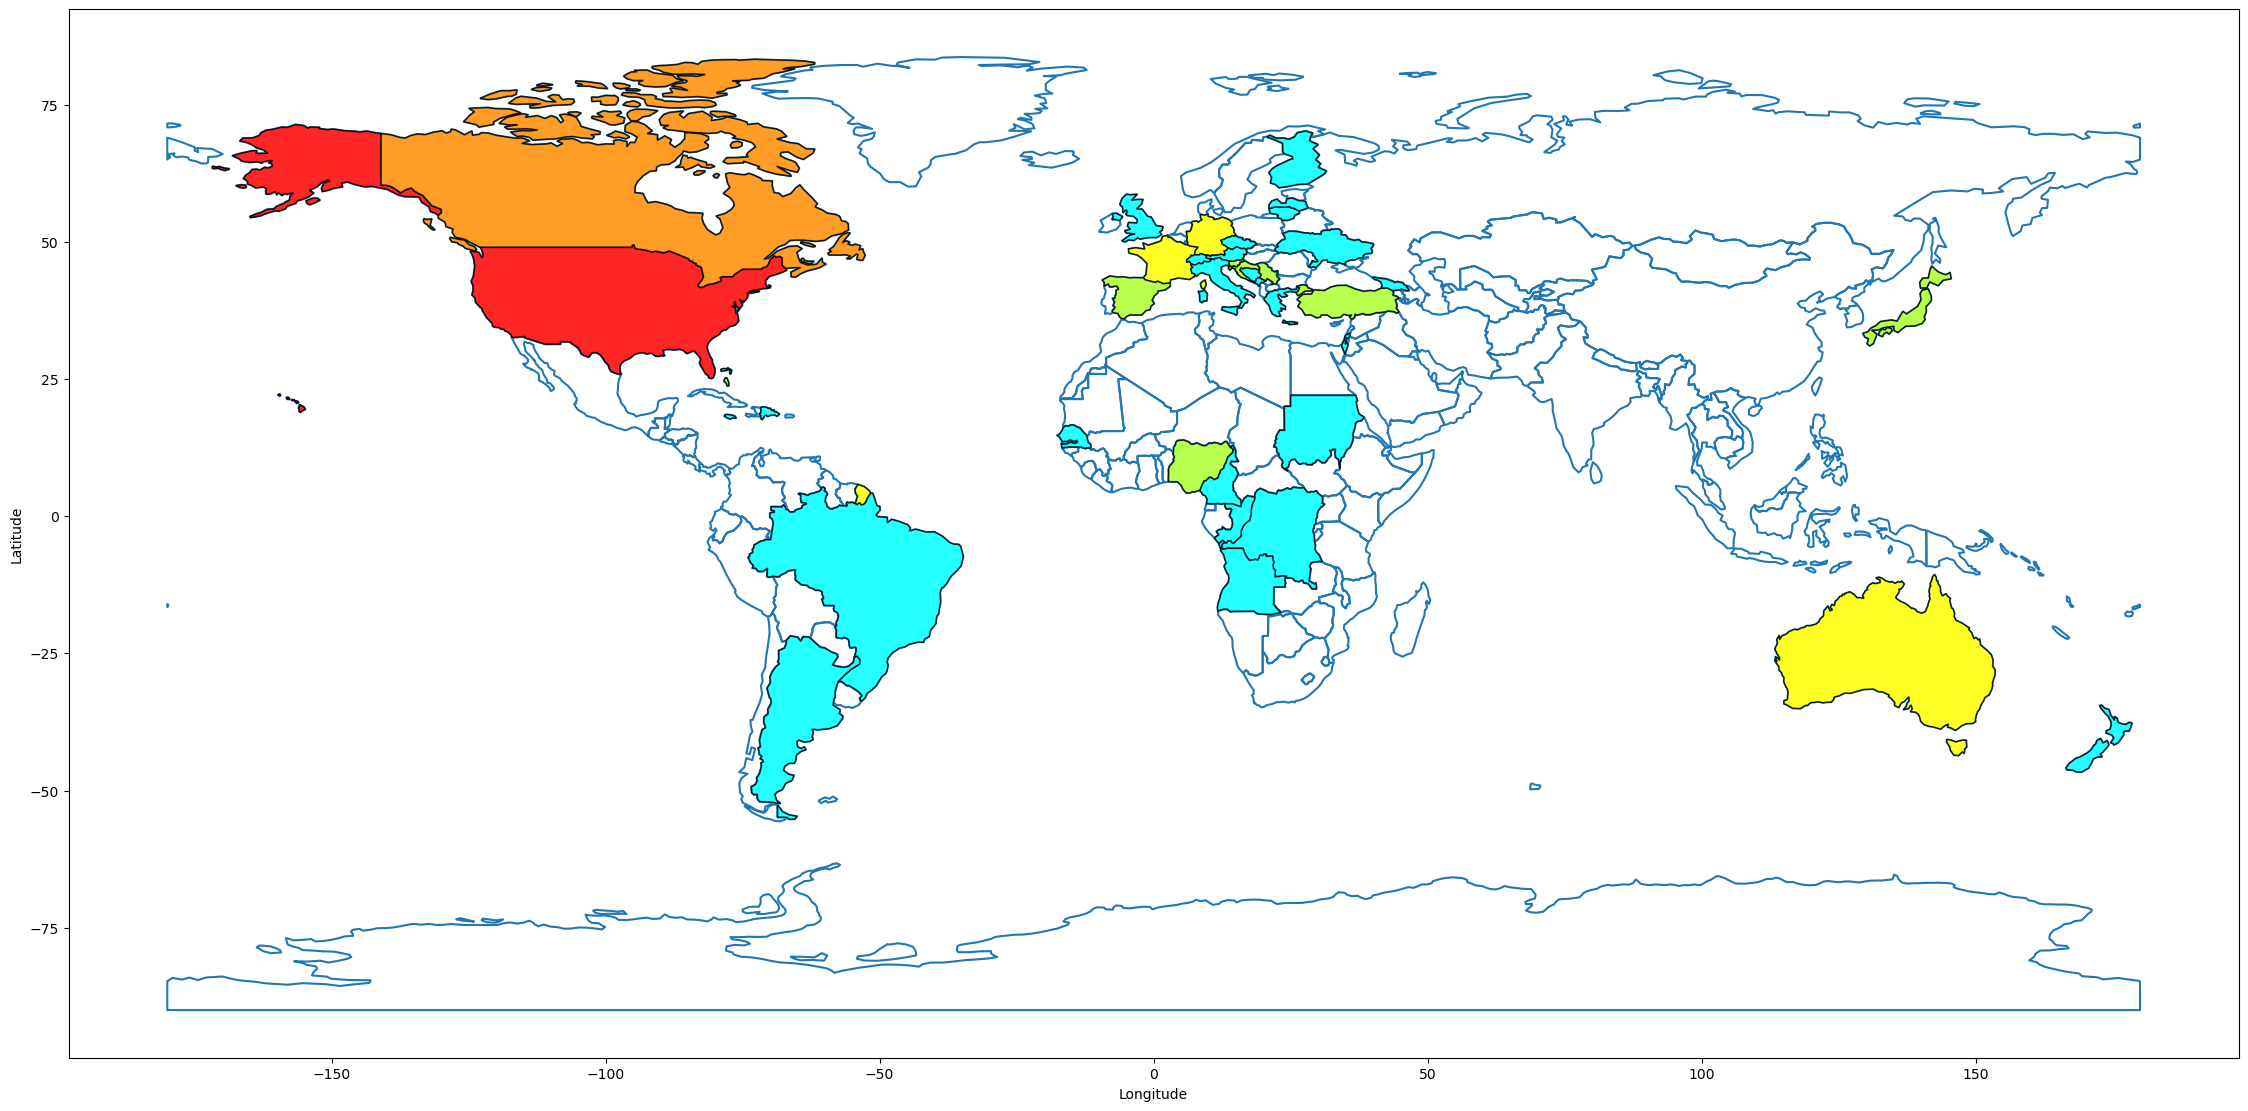

In [18]:
def plotCountryPatch( axes, country_name, fcolor ):
    nami = df_world[df_world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], 'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

def colorea(n):
  if n < 3:
    return "cyan"
  elif n < 6:
    return "greenyellow"
  elif n < 11:
    return "yellow"
  elif n < 21:
    return "darkorange"
  else:
    return "red"

ax2 = df_world["geometry"].boundary.plot(figsize=(28,19))

for coco in countries_dict:
  if coco != "Saint Lucia":
    plotCountryPatch(ax2, coco, colorea(countries_dict[coco]))

plt.ylabel('Latitude')
plt.xlabel('Longitude')
custom_lines = [Line2D([0], [0], color="cyan", lw=4),
                Line2D([0], [0], color="greenyellow", lw=4),
                Line2D([0], [0], color="yellow", lw=4),
                Line2D([0], [0], color="darkorange", lw=4),
                Line2D([0], [0], color="red", lw=4)
               ]

ax2.legend(custom_lines, ['1-2 players', '3-5 players', '6-10 players', "11-20 players", "+300 players"], loc = "center left", fontsize=15)

for fila in nba_world.itertuples():
  if fila.continent!="Europe" or fila.name in ["Spain", "Germany"]:
    y=fila.centroid
    ax2.annotate(s=fila.name, xy=(y.coords[0][0],y.coords[0][1]-5), ha='center')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':


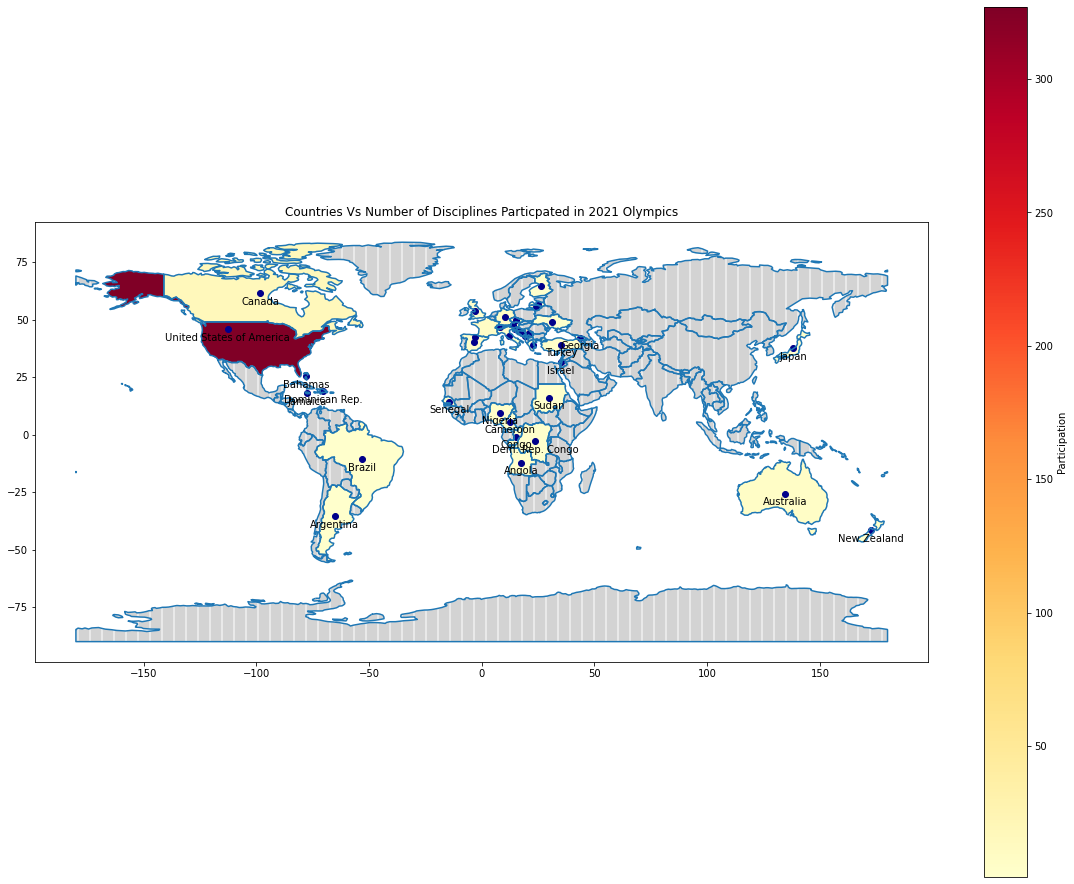

In [ ]:
ax = df_world["geometry"].boundary.plot(figsize=(20,16))
df_world.plot(column="players", ax=ax, cmap='YlOrRd', legend=True, legend_kwds={"label": "Participation"},  missing_kwds={"color": "lightgrey", "edgecolor": "white", "hatch": "|"})
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")
nba_world.centroid.plot(ax=ax, color="DarkBlue")

for fila in nba_world.itertuples():
  if fila.continent!="Europe":
    y=fila.centroid
    ax.annotate(s=fila.name, xy=(y.coords[0][0],y.coords[0][1]-5), ha='center')

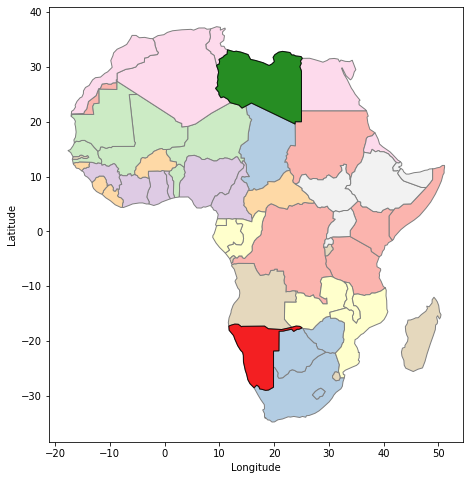

In [ ]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')
print(f"{type(df_world)}, {df_world.geometry.name}")
print(df_world.head())
print(df_world.geometry.geom_type.value_counts())

df_world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )


def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = df_world[df_world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

# plot Africa continent
ax2 = df_world[df_world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')

# then plot some countries on top
plotCountryPatch(ax2, 'Namibia', 'red')
plotCountryPatch(ax2, 'Libya', 'green')

plt.ylabel('Latitude')
plt.xlabel('Longitude')

#ax2.axis('scaled')
plt.show()

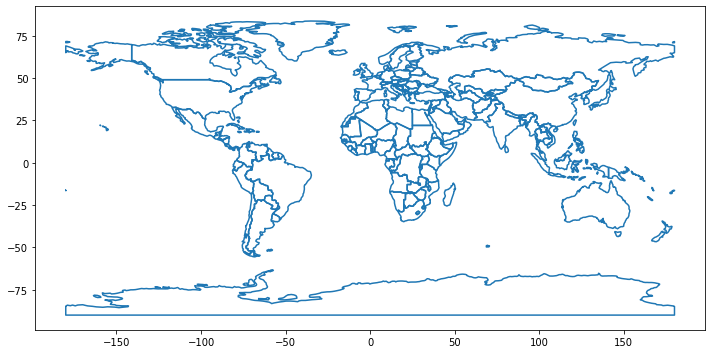

In [ ]:
df_world["geometry"].boundary.plot(figsize=(12,8))

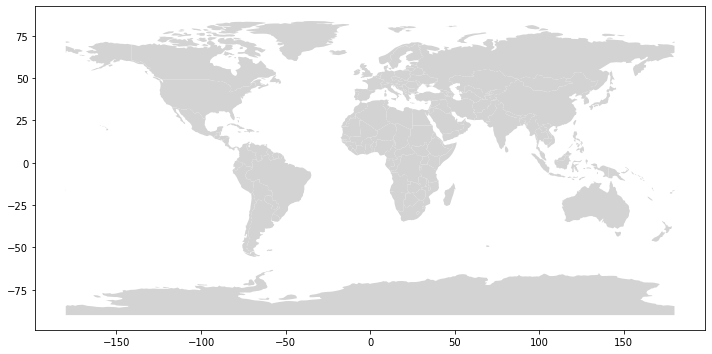

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
df_world.plot(color="lightgrey", ax=ax)

In [ ]:
df_world_teams = df_world.merge(df_teams_countries_disciplines, how="left", left_on=['name'], right_on=['NOC'])
print("Type of DataFrame : ", type(df_world_teams), df_world_teams.shape[0])
df_world_teams.head()

df_world_teams.plot( column="Discipline", ax=ax, cmap='OrRd', 
                     legend=True, legend_kwds={"label": "Participation", "orientation":"horizontal"})
ax.set_title("Countries Vs Number of Disciplines Particpated in 2021 Olympics")